# Validate predicted fixation sites
Data from Smith et al. 2004 paper

In [1]:
library(sitePath)
library(RColorBrewer)
library(ggplot2)
suppressPackageStartupMessages(library(ggtree))
suppressPackageStartupMessages(library(VennDiagram))

DATA_DIR <- file.path("Data", "H3N2_HA1_Smith2004")
OUTPUT_DIR <- file.path("Output", "Tests")
dir.create(OUTPUT_DIR, showWarnings = FALSE)

ANTIGENIC_SITES <- unique(c(
    122, 155, 207, 144, 188,
    137, 164, 53, 174, 145, 189, 278, 102, 193, 213, 217, 230,
    137, 158, 50, 174, 82, 164, 53, 201, 260, 193, 213, 230,
    133, 156, 53, 172, 143, 160, 54, 217, 82, 146, 197, 244,
    124, 155, 189,
    145,
    133, 156, 262, 145, 190,
    145,
    156, 276, 62, 158, 196,
    131, 155, 50, 75, 25, 156, 83, 202, 222, 225
))

CLUSTER_MUTATIONS <- list(
    "HK68-EN72" = c("T122N", "T155Y", "R207K", "G144D", "N188D"),
    "EN72-VI75" = c(
        "N137S", "L164Q", "N53D", "F174S", "S145N", "Q189K", 
        "I278S", "R102K", "S193D", "I213V", "I217V", "I230V"
    ),
    "VI75-TX77" = c(
        "S137Y", "G158E", "K50R", "S174F", "E82K", "Q164L", 
        "D53N", "K201R", "M260I", "D193N", "V213I", "V230I"
    ),
    "TX77-BK79" = c(
        "N133S", "K156E", "N53D", "D172G", "I62K", "P143S", 
        "T160K", "N54S", "V217I", "K82E", "G146S", "Q197R", 
        "V244L"
    ),
    "BK79-SI87" = c("G124D", "Y155H", "K189R"),
    "SI87-BE89" = c("N145K"),
    "BE89-BE92" = c("S133D", "E156K", "T262N", "K145N", "E190D"),
    "BE92-WU95" = c("N145K"),
    "WU95-SY97" = c("K156Q", "N276K", "K62E", "E158K", "V196A"),
    "SY97-FU02" = c(
        "A131T", "H155T", "R50G", "H75Q", "L25I", "Q156H",
        "E83K", "V202I", "W222R", "G225D"
    )
)

In [2]:
makeVennPlot <- function(mutations) {
    overlapped <- intersect(ANTIGENIC_SITES, as.integer(allSitesName(mutations)))
    res <- draw.pairwise.venn(
        area1 = length(mutations),
        area2 = length(ANTIGENIC_SITES),
        cross.area = length(overlapped),
        category = c("Fixation", "Cluster"),
        fill = c("blue", "red"),
        alpha = c(0.1, 0.1),
        lwd = c(3, 3),
        col = c("blue", "red"),
        label.col = c("blue", "black", "red"),
        cat.col = c("blue", "red"),
        cat.just = list(c(1, -1), c(1, -3))
    )
    return(res)
}

getTransMut <- function(mutations) {
    transMut <- list()
    for (site in allSitesName(mutations)) {
        sp <- extractSite(mutations, site)
        for (index in seq_len(length(sp))) {
            mp <- extractTips(sp, index)
            for (i in seq_along(mp)[-1]) {
                prevTips <- mp[[i - 1]]
                currTips <- mp[[i]]
                prevAA <- attr(prevTips, "AA")
                currAA <- attr(currTips, "AA")
                mutation <- paste0(prevAA, site, currAA)
                prevCluster <- unique(clusterInfo[prevTips, ])
                currCluster <- unique(clusterInfo[currTips, ])
#                 if (mutation == "S133D") {
#                     print(prevCluster)
#                     print(currCluster)
#                 }
                for (prev in prevCluster) {
                    for (curr in currCluster) {
                        trans <- paste(prev, curr, sep = "-")
                        if (trans %in% names(CLUSTER_MUTATIONS)) {
                            if (trans %in% names(transMut)) {
                                transMut[[trans]] <- c(transMut[[trans]], mutation)
                            } else {
                                transMut[[trans]] <- mutation
                            }
                        }
                    }
                }
            }
        }
    }
    res <- transMut[match(names(CLUSTER_MUTATIONS), names(transMut))]
    return(res)
}

In [3]:
sequences <- seqinr::read.alignment(file.path(DATA_DIR, "aligned.fasta"), "fasta")
sequences <- sequences$seq

loci <- which(vapply(
    X = seq_len(nchar(sequences[[1]])),
    FUN = function(s) {
        length(unique(substr(sequences, s, s))) > 1
    },
    FUN.VALUE = logical(1)
))
conservedSites <- setdiff(loci, ANTIGENIC_SITES)

siteCategory <- data.frame(
    "site" = c(ANTIGENIC_SITES, conservedSites),
    "category" = c(rep("fixed", length(ANTIGENIC_SITES)),
                   rep("conserved", length(conservedSites))),
    "fixationSite" = c(rep(TRUE, length(ANTIGENIC_SITES)),
                       rep(FALSE, length(conservedSites)))
)

siteCategory <- siteCategory[order(siteCategory[["site"]]), ]
row.names(siteCategory) <- NULL

nPositive <- sum(siteCategory[["fixationSite"]])
nNegative <- sum(!siteCategory[["fixationSite"]])

In [72]:
clusterInfo <- do.call(rbind, lapply(
    X = strsplit(readLines(file.path(DATA_DIR, "metadata_copied.txt")), " "),
    FUN = function(line) {
        seqname <- strsplit(line[[2]], "/")[[1]]
        year <- as.integer(seqname[3])
        if (year >= 50) {
            seqname[3] <- paste0(19, year)
        } else {
            seqname[3] <- paste0(200, year)
        }
        data.frame(
            "id" = paste(seqname, collapse = "/"),
            "cluster" = line[1]
        )
    }
))

group <- split(clusterInfo[["id"]], clusterInfo[["cluster"]])

In [82]:
table(sapply(setdiff(unlist(group, use.names = F), sequences$nam), function(n) {
    clusterInfo[which(clusterInfo[["id"]] == n), "cluster"]
}))


BE89 BE92 BK79 EN72 FU02 HK68 SI87 VI75 WU95 
  31   11    2    1    3    2    5    1    2 

In [69]:
sequences <- seqinr::read.alignment(file.path(DATA_DIR, "aligned.fasta"), "fasta")

sequences$nam

In [4]:
clusterInfo <- read.csv(
    file.path(DATA_DIR, "metadata.csv"),
    stringsAsFactors = FALSE,
    row.names = 1
)

group <- split(rownames(clusterInfo), clusterInfo[["cluster"]])

groupColors <- colorRampPalette(brewer.pal(9, "Set1"))(length(group))
names(groupColors) <- names(group)
groupColors["0"] <- "black"

# 1. RAxML
Run `Data/H3N2_HA1_Smith2004/run_raxml.sh` to build the phylogenetic tree.

In [5]:
tree <- read.tree(file.path(DATA_DIR, "RAxML_bestTree.PROTGAMMAGTR"))
paths <- addMSA(tree, file.path(DATA_DIR, "aligned.fasta"), "fasta")

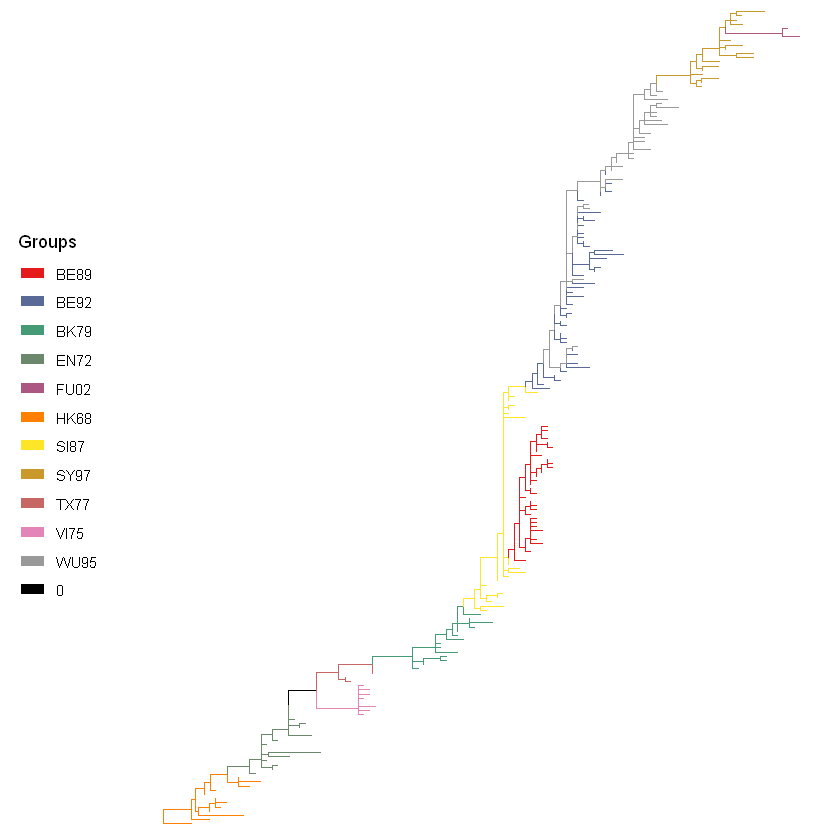

In [6]:
p <- ggtree(groupOTU(tree, group, group_name = "Groups"), aes(color = Groups)) +
    scale_color_manual(values = as.list(groupColors), limits = names(groupColors)) +
    guides(
      color = guide_legend(
        override.aes = list(size = 3)
      )
    ) +
    theme(legend.position = "left")
p

ggsave(filename = file.path(OUTPUT_DIR, "Smith2004_tree.pdf"), plot = p, width = 6, height = 4)

In [7]:
mutations <- fixationSites(paths)
mutations

This is a 'fixationSites' object.

Result for 3 paths:

2 3 50 53 54 62 78 82 83 94 121 122 124 126 131 133 135 137 143 144 145 146 155 156 158 159 160 163 164 172 173 174 188 189 193 196 197 201 207 213 217 230 242 244 248 260 275 278 299 307 157 190 214 219 262 276 57 142 192 226 
No reference sequence specified. Using alignment numbering

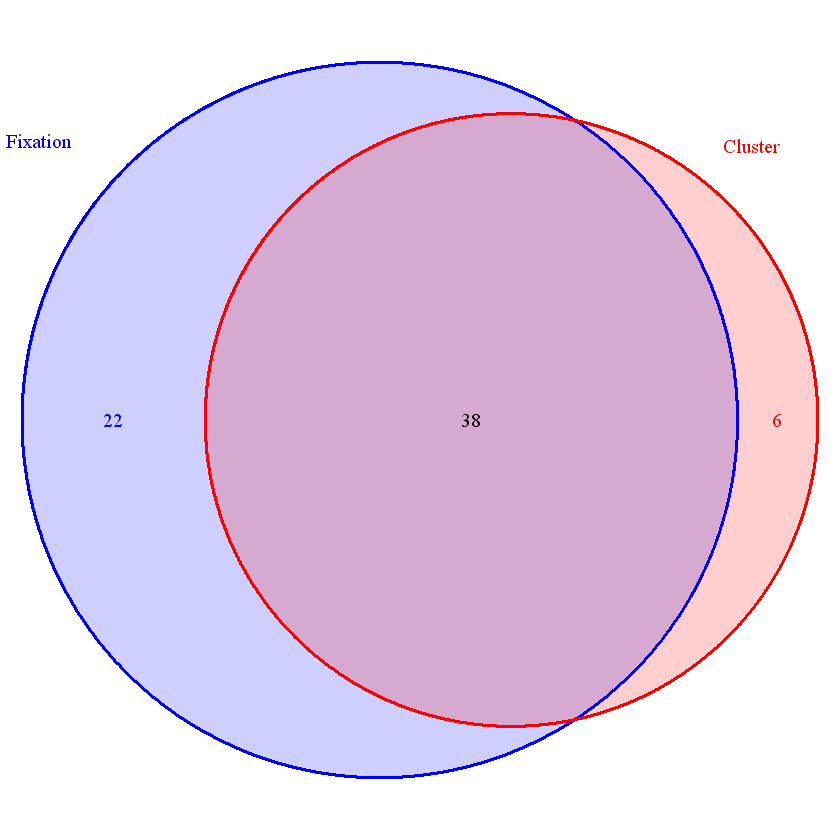

In [8]:
venn.plot <- makeVennPlot(mutations)

grid.draw(venn.plot)

pdf(file = file.path(OUTPUT_DIR, "Smith2004_venn.pdf"), width = 1.5, height =1.5)
grid.draw(venn.plot)
invisible(dev.off())

In [84]:
nchar(sequences$seq[[1]])

[1] 329

In [10]:
transMut

$`HK68-EN72`
 [1] "L3F"   "V78G"  "T83K"  "T122N" "T126N" "G144D" "T155Y" "N188D" "S193N"
[10] "S193N" "R207K" "V242I" "D275G" "D275G"

$`EN72-VI75`
 [1] "F3L"   "N53D"  "T83K"  "T126N" "N137Y" "N137Y" "L164Q" "F174S" "N188D"
[10] "Q189K" "Q189K" "S193N" "S193N" "R201K" "I213V" "I217V" "I230V" "I278S"
[19] "I278S"

$`VI75-TX77`
 [1] "D2N"   "K50R"  "N54S"  "I62K"  "I62K"  "G158E" "G158E" "Q164L" "D172G"
[10] "D172G" "D172G" "S174F" "K201R" "V230I" "V244L" "M260I"

$`TX77-BK79`
 [1] "D2N"   "N2K"   "N54S"  "I62K"  "I62K"  "G124D" "G124D" "N133S" "N133S"
[10] "N133S" "P143S" "D144V" "G146S" "S159Y" "T160K" "V163A" "D172G" "D172G"
[19] "D172G" "N173K" "Q197R" "Q197R" "V217I" "V244L" "N248T" "K307R"

$`BK79-SI87`
 [1] "N2K"   "E82K"  "K83E"  "F94Y"  "G124D" "G124D" "T131A" "G135E" "D144V"
[10] "Y155H" "K156E" "S159Y" "V163A" "N173K" "K189R" "K189R" "N193S" "N248T"
[19] "K299R" "K307R" "E190D" "T262N" "T262N"

$`SI87-BE89`
 [1] "E82K"  "K83E"  "F94Y"  "I121T" "T131A" "G135E" "N145K" "K156E" "G172D"
[10] "N193S" "V196I" "K299R"

$<NA>
NULL

$`BE92-WU95`
 [1] "I121T" "T121N" "D124G" "G124S" "D133N" "G135K" "G135K" "K135T" "N145K"
[10] "G172D" "R189S" "R197Q" "G275D" "S278N" "S157L" "I214T" "T214I" "S219F"
[19] "N262S" "T276N" "T276N" "L226I" "I226V"

$`WU95-SY97`
 [1] "K62E"  "T121N" "G124S" "D133N" "K135T" "Y137S" "N145K" "E158K" "G172D"
[10] "D172E" "V196A" "R197Q" "D275G" "S278N" "T214I" "N262S" "N276K" "R57Q" 
[19] "G142R" "T192I" "I226V"

$`SY97-FU02`
[1] "Y137S" "D172E" "R57Q"  "G142R" "T192I"

In [11]:
CLUSTER_MUTATIONS

$`HK68-EN72`
[1] "T122N" "T155Y" "R207K" "G144D" "N188D"

$`EN72-VI75`
 [1] "N137S" "L164Q" "N53D"  "F174S" "S145N" "Q189K" "I278S" "R102K" "S193D"
[10] "I213V" "I217V" "I230V"

$`VI75-TX77`
 [1] "S137Y" "G158E" "K50R"  "S174F" "E82K"  "Q164L" "D53N"  "K201R" "M260I"
[10] "D193N" "V213I" "V230I"

$`TX77-BK79`
 [1] "N133S" "K156E" "N53D"  "D172G" "I62K"  "P143S" "T160K" "N54S"  "V217I"
[10] "K82E"  "G146S" "Q197R" "V244L"

$`BK79-SI87`
[1] "G124D" "Y155H" "K189R"

$`SI87-BE89`
[1] "N145K"

$`BE89-BE92`
[1] "S133D" "E156K" "T262N" "K145N" "E190D"

$`BE92-WU95`
[1] "N145K"

$`WU95-SY97`
[1] "K156Q" "N276K" "K62E"  "E158K" "V196A"

$`SY97-FU02`
 [1] "A131T" "H155T" "R50G"  "H75Q"  "L25I"  "Q156H" "E83K"  "V202I" "W222R"
[10] "G225D"